In [1]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from hydra import compose, initialize

from src.analysis.utils import (
    get_elsevier_single_column_fig,
    get_elsevier_one_and_half_column_fig,
    get_elsevier_double_column_fig,
    get_elsevier_figure_with_subplots
)
from src.modeling.utils import (
    regression_metrics
)

In [2]:
plt.rcParams.update({
    "font.size": 9,
    'lines.linewidth': 1,
})

SAVE_FIGURES = True

In [3]:
with initialize(version_base=None, config_path='../../src/conf'):
    cfg = compose(config_name="config")

In [4]:
evaluation_results_dir = Path('../../') / cfg['modeling']['evaluation_results_dir']
model_partial = cfg["model"]
model_name = model_partial["_target_"].split(".")[-1]

target = cfg["modeling"]["target"]

evaluation_results_dir /= f"{model_name}_{target}_evaluation"

predictions_path = evaluation_results_dir / "predictions.csv"

In [5]:
predictions = pd.read_csv(predictions_path)

In [ ]:
def scatter_plot(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    model_name: str,
    target_name: str,
):
    """Plot y_true vs y_pred with regression line, ideal line, and metrics legend.

    Parameters
    ----------
    y_true : array-like
        True target values.
    y_pred : array-like
        Predicted target values.
    model_name : str
        Name of the model (for the title).
    target_name : str
        Name of the target variable (for the title).

    Returns
    -------
    tuple
        Plot's fig and ax.
    """
    metrics = regression_metrics(y_true, y_pred)

    # Compute metrics
    mae = metrics["mae"]
    rmse = metrics["rmse"]
    r2 = metrics["r2"]
    r = metrics["r"]

    # Fit regression line
    slope, intercept = np.polyfit(y_true, y_pred, 1)
    line_x = np.linspace(min(y_true), max(y_true), 100)
    reg_line = slope * line_x + intercept

    # Ideal line
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ideal_line = np.linspace(min_val, max_val, 100)

    # Plot
    fig, ax = get_elsevier_one_and_half_column_fig(height_mm=90)
    ax.scatter(y_true, y_pred, alpha=0.7, label="Estimations")
    ax.plot(line_x, reg_line, label=f"Fit line\na={slope:.2f}\nb={intercept:.2f}", color="red", linestyle="--")
    ax.plot(ideal_line, ideal_line, label="Ideal (y = x)", color="black", linestyle="--")

    ax.set_xlabel(f"Reference {target_name}")
    ax.set_ylabel(f"Estimated {target_name}")
    ax.set_title(f"{model_name} - {target_name} Estimation")

    # Add metrics to legend
    metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR: {r:.2f}\nR²: {r2:.2f}"
    ax.legend(title=metrics_text, loc="best")

    ax.grid(True)
    return fig, ax

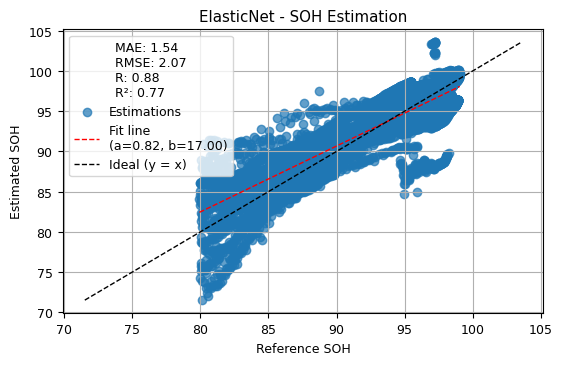

In [15]:
y_true = predictions["y_true"]
y_pred = predictions["y_pred"]

fig, ax = scatter_plot(y_true, y_pred, model_name, target)

plt.show()